In [18]:
import numpy as np
from astropy.io import fits

testarr = [['ac','df', 'gi'],
          ['jl','mo', 'pr'],
          ['su','vx', 'ya'],
          ['xx','yy', 'zz']]
testarr = np.array(testarr)

n = np.zeros((4,3))
primary_hdu = fits.PrimaryHDU(n)

test_hdu = fits.BinTableHDU.from_columns([
                fits.Column(name='testarr', format='24A', array=testarr)
                ])
hdul = fits.HDUList([primary_hdu, test_hdu])


ValueError: could not broadcast input array from shape (12,) into shape (4,)

In [ ]:
hdul[0]

# Set Up

In [1]:
#command line items
%load_ext autoreload
%autoreload 2

#python imports
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from copy import copy
from numpy import nan
import pandas


from pylab import *
import astropy.io.fits as fits
from scipy.io import readsav
from matplotlib.colors import LogNorm
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import matplotlib.patches as patches
#from plot_grids import *
import scipy.integrate as integrate

Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
Yellow = '\033[93m'
Magenta = '\033[95m'
CEND = '\033[0m'

/tmp/ipykernel_29752/3860017640.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate Scales

In [2]:
# ions wavelenghts
o2 = [3726.03, 3728.82]
mg2 = [2795.5301, 2802.7056]
o3 = [4958.911,5006.843]

#Redshift of the source
z = 0.043118

#check that the python library gives the same result as the  manual calculation
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.725)
arcsec_kpc = cosmo.arcsec_per_kpc_proper(z) 
deg_kpc = arcsec_kpc / 60. /60. # degree size of 1 kpc

print(Green + 'Check using FlatLambdaCDM, scale:' + CEND, arcsec_kpc, 1/arcsec_kpc)

#Set some constants
h0 = 67.4
Om = 0.315
Ol = 1 - Om
c_light = 299792.458

#Estimate the Angular Diameter Distance 
def func(x):
    return 1/np.sqrt( Om * (1+x)**3 + Ol)

result = integrate.quad(lambda x: func(x), 0, z)
da = c_light/h0*1/(1+z)* (result[0])
print(Red + 'Angular Diameter Distance is' + CEND, da, Red + 'Mpc' + CEND)

# 4.84814e-6 is rad in arcsec, 1000 is to have the scale in kpc
x_ = da * 1000 * 4.84814e-6

# 8.096e-5 is the pixel scale along slice, 3600 is to convert it in arcsec (0.291456)
pixel_size = 8.096e-5 * 3600
pixel_scale = x_ * pixel_size


arcsec_pixel =  pixel_scale / x_

print (Blue + "Scale: 1 arcsec is" + CEND, x, Blue + "kpc" + CEND)
print (Magenta + "Scale: 1 pixel is" + CEND, pixel_scale, Magenta + "kpc" + CEND)
print (Cyan + "FOV for z" + CEND, z, Cyan + "is" + CEND, 16.5 * x, 'x', 20.4 * x, Cyan + "kpc" + CEND,)
print (Yellow + "Scale: 1 pixel is" + CEND, arcsec_pixel, Yellow + "arcsec" + CEND)


Check using FlatLambdaCDM, scale: 1.1335033945669866 arcsec / kpc 0.8822205604262997 kpc / arcsec
Angular Diameter Distance is 181.9717830858933 Mpc


NameError: name 'x' is not defined

# PATH TO FOLDERS

In [32]:
"""CHANGE THESE PATHS"""

path_1comp_fit = '/home/acoil/AGN_outflows_ifsfit/F05189/iter3/' #This is the 1 component fit
path_2comp_fit = '/raid/KCWI/AGN_outflows/F05189/iter2/' #This is the 2 compoents fit (not OIII)
path_3comp_fit = '/home/acoil/AGN_outflows_ifsfit/F05189/iter5/' #This is the 3 components fit


# Define the ION you want to explore

In [4]:
"""CHANGE ion, ion_tag AS NEEDED"""

ion = 5    #change this with the index of the ion you want
ion_tag = 'o2'    #change this in 'o2' or o3' 


"""DON'T CHANGE THESE"""
if ion_tag == 'o2':
    plot_limits = ((z+1)*o2[1] - 70, (z+1)*o2[1] + 70)
    ion_line = [b'[OII]3726', b'[OII]3729']
    ion_wave_0 = o2[0]
    ion_wave_1 = o2[1]
    vel_lim=[-2500,2500]

elif ion_tag == 'o3':
    plot_limits = ((z+1)*o3[1] - 70, (z+1)*o3[1] + 70)
    ion_line = [b'[OIII]5007']
    ion_wave_0 = o3[0]
    ion_wave_1 = o3[1]
    vel_lim=[-2500,2500]


In [5]:
"""CHANGE err_thresh AFTER FINDING IT USING THE BELOW PLOTTING FUNCTIONS"""

err_thresh =  0.0014 #set the error threshold after exploring the error arrays


# Functions to get data for maps

In [6]:
def set_sn(arr, arr2):
    sn_cut = np.where(arr < 3) #change here the SN threshold, now set to 3
    arr2[sn_cut] = nan   #if the SN is less than 5, remove that spaxel
    return arr2

def set_bad(arr):
    bad = (arr > 1e90)   
    arr[bad] = nan   
   # bad2 = (arr < 1e-26)
   # arr[bad2] = nan
    return arr   

def get_flux_uncorr(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)  

    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
        
    sn = f/f_err
    f = set_sn(sn,f)  
    return f

def get_err_flux(idx, arr):
    f_err = copy(arr[idx][1])
    f_err = set_bad(f_err)  
    
    return f_err

    
def get_v50(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])

    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v 

def get_vsig(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_v02(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_v98(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

# Read and Load

## Read Files (1comp fit)

In [11]:
data_1comp = readsav(path_1comp_fit+'F05189.xdr')
data_arr_1comp = data_1comp['windstr']
# print(data_arr_1comp.dtype.names)

lin_data_1comp = readsav(path_1comp_fit+'F05189.lin.xdr')
# print(lin_data_1comp.keys())

## Load Arrays (1comp fit)

In [30]:
data_flx_1comp = lin_data_1comp['emlflx'][0][8]
data_flx_err_1comp = lin_data_1comp['emlflxerr'][0][8]
vel_arr_1comp = data_arr_1comp['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx_1comp)):
    if data_flx_1comp[i][0] != None:
        print(i,data_flx_1comp[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr_1comp)):
    if vel_arr_1comp[i][0] != None:
        print(i,vel_arr_1comp[i][0])        

## Get indices (1comp fit)

In [ ]:
"""CHANGE THESE INDICES ACCORDING TO ABOVE"""

fc1_1comp_idx = 5

vsig_c1_1comp_idx = 8
v50_c1_1comp_idx = 5
v98_c1_1comp_idx = 28
v02_c1_1comp_idx = 4

## Read Files (2comp fit)

In [11]:
data_2comp = readsav(path_2comp_fit+'F05189.xdr')
data_arr_2comp = data_2comp['windstr']
# print(data_arr_2comp.dtype.names)

lin_data_2comp = readsav(path_2comp_fit+'F05189.lin.xdr')
# print(lin_data_2comp.keys())

## Load Arrays (2comp fit)

In [30]:
data_flx_2comp = lin_data_2comp['emlflx'][0][8]
data_flx_err_2comp = lin_data_2comp['emlflxerr'][0][8]
vel_arr_2comp = data_arr_2comp['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx_2comp)):
    if data_flx_2comp[i][0] != None:
        print(i,data_flx_2comp[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr_2comp)):
    if vel_arr_2comp[i][0] != None:
        print(i,vel_arr_2comp[i][0])        

## Get indices (2comp fit)

In [ ]:
"""CHANGE THESE INDICES ACCORDING TO ABOVE"""

fc1_2comp_idx = 5
fc2_2comp_idx = 1

vsig_c1_2comp_idx = 10
v50_c1_2comp_idx = 5
v98_c1_2comp_idx = 28
v02_c1_2comp_idx = 4

vsig_c2_2comp_idx = 12
v50_c2_2comp_idx = 18
v98_c2_2comp_idx = 8
v02_c2_2comp_idx = 21

## Read Files (3comp fit)

In [7]:
data_3comp = readsav(path_3comp_fit+'F05189.xdr')
data_arr_3comp = data_3comp['windstr']
# print(data_arr_3comp.dtype.names)

lin_data_3comp = readsav(path_3comp_fit+'F05189.lin.xdr')
# print(lin_data_3comp.keys())

## Load Arrays (3comp fit)

In [8]:
data_flx_3comp = lin_data_3comp['emlflx'][0][8]
data_flx_err_3comp = lin_data_3comp['emlflxerr'][0][8]
vel_arr_3comp = data_arr_3comp['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx_3comp)):
    if data_flx_3comp[i][0] != None:
        print(i,data_flx_3comp[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr_3comp)):
    if vel_arr_3comp[i][0] != None:
        print(i,vel_arr_3comp[i][0])        

###### FLUX AND ERR #########
0 b'ftot'
1 b'fc2'
3 b'fc3pk'
4 b'fc2pk'
5 b'fc1'
6 b'fc1pk'
7 b'fc3'
####### VEL ########
0 b'v%02c3'
2 b'v%50c3'
3 b'vsigc3'
4 b'v%02c1'
5 b'v%50c1'
8 b'v%84c3'
9 b'v%98'
10 b'vsigc3err'
11 b'vsigc1'
12 b'vsigc2'
15 b'v%50'
16 b'v%50c2'
18 b'v%50c3err'
19 b'vsigc2err'
20 b'v%02c2'
24 b'v%50c1err'
27 b'v%98c1'
32 b'v%84c1'
40 b'v%98c2'
42 b'v%16c3'
43 b'v%16'
45 b'v%84c2'
46 b'vpk'
48 b'vsig'
49 b'v%02'
50 b'v%50c2err'
51 b'vsigc1err'
53 b'v%98c3'
56 b'v%16c2'
59 b'v%84'
63 b'v%16c1'


## Total Flux (3comp fit)

In [15]:
ftot_3comp = data_flx_3comp[0][1][0][8]
err_ftot_3comp = data_flx_err_3comp[0][1][0][8]

print('####### LINES ########') 
for i in range(len(ftot_3comp)):
    if ftot_3comp[i][0] != None:
        print(i,ftot_3comp[i][0])

####### LINES ########
0 b'Hbeta'
3 b'[NeIII]3967'
4 b'[OII]3726'
5 b'[OII]3726+[OII]3729'
9 b'[NeIII]3869'
10 b'[NeIII]3869+[NeIII]3967'
12 b'[OII]3729'
13 b'[OIII]4959'
14 b'[OIII]5007'
15 b'Hgamma'


## Get indices (3comp fit)

In [20]:
"""CHANGE THESE INDICES ACCORDING TO ABOVE"""

fc1_3comp_idx = 5
fc2_3comp_idx = 1
fc3_3comp_idx = 7

vsig_tot_3comp_idx = 48
v50_tot_3comp_idx = 15
v98_tot_3comp_idx = 9
v02_tot_3comp_idx = 49

vsig_c1_3comp_idx = 11
v50_c1_3comp_idx = 5
v98_c1_3comp_idx = 27
v02_c1_3comp_idx = 4

vsig_c2_3comp_idx = 12
v50_c2_3comp_idx = 16
v98_c2_3comp_idx = 40
v02_c2_3comp_idx = 20

vsig_c3_3comp_idx = 3
v50_c3_3comp_idx = 2
v98_c3_3comp_idx = 53
v02_c3_3comp_idx = 0

# Flux and Velocity Arrays

# 1comp fit Flux and Velocity Arrays

## c1 (1comp fit)

In [ ]:
# using c1 data 
fc_1comp = data_flx_1comp[fc1_1comp_idx][1][0][8]
err_fc_1comp = data_flx_err_1comp[fc1_1comp_idx][1][0][8]

vsig_1comp = vel_arr_1comp[vsig_c1_1comp_idx][1][0][8]
v50_1comp = vel_arr_1comp[v50_c1_1comp_idx][1][0][8]
v98_1comp = vel_arr_1comp[v98_c1_1comp_idx][1][0][8]
v02_1comp = vel_arr_1comp[v02_c1_1comp_idx][1][0][8]

snr_1comp = get_sn(ion,fc_1comp,err_fc_1comp)

# 2comp fit Flux and Velocity Arrays

## c1 (2comp fit)

In [ ]:
fc1_2comp = data_flx_2comp[fc1_2comp_idx][1][0][8]
err_fc1_2comp = data_flx_err_2comp[fc1_2comp_idx][1][0][8]

vsig_c1_2comp = vel_arr_2comp[vsig_c1_2comp_idx][1][0][8]
v50_c1_2comp = vel_arr_2comp[v50_c1_2comp_idx][1][0][8]
v98_c1_2comp = vel_arr_2comp[v98_c1_2comp_idx][1][0][8]
v02_c1_2comp = vel_arr_2comp[v02_c1_2comp_idx][1][0][8]


snr_c1_2comp = get_sn(ion,fc1_2comp,err_fc1_2comp)

## c2 (2comp fit)

In [ ]:
fc2_2comp = data_flx_2comp[fc2_2comp_idx][1][0][8]
err_fc2_2comp = data_flx_err_2comp[fc2_2comp_idx][1][0][8]

vsig_c2_2comp = vel_arr_2comp[vsig_c2_2comp_idx][1][0][8]
v50_c2_2comp = vel_arr_2comp[v50_c2_2comp_idx][1][0][8]
v98_c2_2comp = vel_arr_2comp[v98_c2_2comp_idx][1][0][8]
v02_c2_2comp = vel_arr_2comp[v02_c2_2comp_idx][1][0][8]

snr_c2_2comp = get_sn(ion,fc2_2comp,err_fc2_2comp)

# 3comp fit Flux and Velocity Arrays

## tot (3comp fit)

In [22]:
ftot_3comp = data_flx_3comp[0][1][0][8]
err_ftot_3comp = data_flx_err_3comp[0][1][0][8]

vsig_tot_3comp = vel_arr_3comp[vsig_tot_3comp_idx][1][0][8]
v50_tot_3comp = vel_arr_3comp[v50_tot_3comp_idx][1][0][8]
v98_tot_3comp = vel_arr_3comp[v98_tot_3comp_idx][1][0][8]
v02_tot_3comp = vel_arr_3comp[v02_tot_3comp_idx][1][0][8]

## c1 (3comp fit)

In [10]:
fc1_3comp = data_flx_3comp[fc1_3comp_idx][1][0][8]
err_fc1_3comp = data_flx_err_3comp[fc1_3comp_idx][1][0][8]

vsig_c1_3comp = vel_arr_3comp[vsig_c1_3comp_idx][1][0][8]
v50_c1_3comp = vel_arr_3comp[v50_c1_3comp_idx][1][0][8]
v98_c1_3comp = vel_arr_3comp[v98_c1_3comp_idx][1][0][8]
v02_c1_3comp = vel_arr_3comp[v02_c1_3comp_idx][1][0][8]

snr_c1_3comp = get_sn(ion,fc1_3comp,err_fc1_3comp)

## c2 (3comp fit)

In [11]:
fc2_3comp = data_flx_3comp[fc2_3comp_idx][1][0][8]
err_fc2_3comp = data_flx_err_3comp[fc2_3comp_idx][1][0][8]

vsig_c2_3comp = vel_arr_3comp[vsig_c2_3comp_idx][1][0][8]
v50_c2_3comp = vel_arr_3comp[v50_c2_3comp_idx][1][0][8]
v98_c2_3comp = vel_arr_3comp[v98_c2_3comp_idx][1][0][8]
v02_c2_3comp = vel_arr_3comp[v02_c2_3comp_idx][1][0][8]

snr_c2_3comp = get_sn(ion,fc2_3comp,err_fc2_3comp)

## c3 (3comp fit)

In [12]:
fc3_3comp = data_flx_3comp[fc3_3comp_idx][1][0][8]
err_fc3_3comp = data_flx_err_3comp[fc3_3comp_idx][1][0][8]

vsig_c3_3comp = vel_arr_3comp[vsig_c3_3comp_idx][1][0][8]
v50_c3_3comp = vel_arr_3comp[v50_c3_3comp_idx][1][0][8]
v98_c3_3comp = vel_arr_3comp[v98_c3_3comp_idx][1][0][8]
v02_c3_3comp = vel_arr_3comp[v02_c3_3comp_idx][1][0][8]

snr_c3_3comp = get_sn(ion,fc3_3comp,err_fc3_3comp)

# START HERE

# Set up new FITS file

In [16]:
fits_y = len(ftot_3comp[5][1])
fits_x = len(ftot_3comp[5][1][0])

print('rows: ', fits_y)
print('columns: ', fits_x)

rows:  97
columns:  74


# Check for second component in 2comp fit

In [49]:
check_c1 = np.zeros((fits_y, fits_x))
check_c2 = np.zeros((fits_y, fits_x))
check_c3 = np.zeros((fits_y, fits_x))

for i in np.arange(fits_y):
    for j in np.arange(fits_x):
#         # check c1
#         if (fc1_3comp[5][1][i][j] != 0. and fc1_3comp[5][1][i][j] < 1e+99 
#             and fc2_3comp[5][1][i][j] != 0 
#             and fc3_3comp[5][1][i][j] != 0.):
#             check_c1[i][j] = 1.
            
#         # check c2
#         if (fc1_3comp[5][1][i][j] != 0. 
#             and fc2_3comp[5][1][i][j] != 0 and fc2_3comp[5][1][i][j] < 1e+99 
#             and fc3_3comp[5][1][i][j] != 0.):            
#             check_c2[i][j] = 1.
            
#         # check c3
#         if (fc1_3comp[5][1][i][j] != 0. 
#             and fc2_3comp[5][1][i][j] != 0  
#             and fc3_3comp[5][1][i][j] != 0. and fc3_3comp[5][1][i][j] < 1e+99):
#             check_c3[i][j] = 1.
            
        # check c1
        if (fc1_3comp[5][1][i][j] != 0. and fc1_3comp[5][1][i][j] < 1e+99):
            check_c1[i][j] = 1.
            
        # check c2
        if (fc2_3comp[5][1][i][j] != 0 and fc2_3comp[5][1][i][j] < 1e+99 ):            
            check_c2[i][j] = 1.
            
        # check c3
        if (fc3_3comp[5][1][i][j] != 0. and fc3_3comp[5][1][i][j] < 1e+99):
            check_c3[i][j] = 1.

# Identify first vs second component and populate new FITS file

In [15]:
# ftot
# fc1
# fc2
# fc3
# err_fc1
# err_fc2
# err_fc3

# vsig_tot
# v50_tot
# v98_tot
# v02_tot

# vsig_c1
# v50_c1
# v98_c1
# v02_c1

# vsig_c2
# v50_c2
# v98_c2
# v02_c2

# vsig_c3
# v50_c3
# v98_c3
# v02_c3

# snr_tot
# snr_c1
# snr_c2
# snr_c3

In [50]:
# initialize arrays

n = np.zeros((fits_y, fits_x))
ftot_arr = np.copy(n)
fc1_arr = np.copy(n)
fc2_arr = np.copy(n)
fc3_arr = np.copy(n)
err_ftot_arr = np.copy(n)
err_fc1_arr = np.copy(n)
err_fc2_arr = np.copy(n)
err_fc3_arr = np.copy(n)
vsig_tot_arr = np.copy(n)
v50_tot_arr = np.copy(n)
v98_tot_arr = np.copy(n)
v02_tot_arr = np.copy(n)
vsig_c1_arr = np.copy(n)
v50_c1_arr = np.copy(n)
v98_c1_arr = np.copy(n)
v02_c1_arr = np.copy(n)
vsig_c2_arr = np.copy(n)
v50_c2_arr = np.copy(n)
v98_c2_arr = np.copy(n)
v02_c2_arr = np.copy(n)
vsig_c3_arr = np.copy(n)
v50_c3_arr = np.copy(n)
v98_c3_arr = np.copy(n)
v02_c3_arr = np.copy(n)

In [51]:
# populate arrays

break_out_flag = False
switch_arr = np.zeros((fits_y, fits_x))
######## TODO ##########
# make switch_arr empty strings instead of zeros
#
#
#
#
#
#
#

"""
0.0 s123 – no switch
0.1 s132 – c2 and c3 switch
0.2 s321 – c1 and c3 switch
0.3 s213 – c1 and c2 switch
0.11 s231 – switch
0.12 s312 – switch
##### the following: always save in c1, then c2, then c3 #####
##### so if no c1, and c2
1.0 s012 – no c1, no switch
1.1 s021 – no c1, switch
2.0 s102 – no c2, no switch
2.1 s201 – no c2, switch
3.0 s120 – no c3, no switch
3.1 s210 – no c3, switch
4.3 s001 – no c1 and c2
4.2 s010 – no c1 and c3
4.1 s100 – no c2 and c3
8.0 s000 – no data
9.0 s999 – unknown case???
"""

##################################
# v98 trial
# normal case, from left to right: 
# c3 -> c2 -> c1
##################################

for i in np.arange(fits_y):
    for j in np.arange(fits_x):
        
        test_c1 = v98_c1_3comp[ion][1][i][j]
        test_c2 = v98_c2_3comp[ion][1][i][j]
        test_c3 = v98_c3_3comp[ion][1][i][j]
        
        # have c1, c2, c3
        if (check_c1[i][j] == 1. and check_c2[i][j] == 1. and check_c3[i][j] == 1. ):
            
            # s123
            if (test_c1 > test_c2 and test_c2 > test_c3):
                switch_arr[i][j] = 0.0  # 's123'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc1_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc2_3comp[ion][1][i][j]
                fc3_arr[i][j] = fc3_3comp[ion][1][i][j]
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc1_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc2_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = err_fc3_3comp[ion][1][i][j]

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c1_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c2_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c3_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c3_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c3_arr[i][j] = v02_c3_3comp[ion][1][i][j]
                
            # s132
            elif (test_c1 > test_c3 and test_c3 > test_c2):
                switch_arr[i][j] = 0.1  # 's132'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc1_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc3_3comp[ion][1][i][j]
                fc3_arr[i][j] = fc2_3comp[ion][1][i][j]
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc1_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc3_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = err_fc2_3comp[ion][1][i][j]

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c1_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c3_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c3_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c3_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c3_arr[i][j] = v02_c2_3comp[ion][1][i][j]
            
            # s321
            elif (test_c3 > test_c2 and test_c2 > test_c1):
                switch_arr[i][j] = 0.2  # 's321'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc3_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc2_3comp[ion][1][i][j]
                fc3_arr[i][j] = fc1_3comp[ion][1][i][j]
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc3_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc2_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = err_fc1_3comp[ion][1][i][j]

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c3_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c2_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c3_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c3_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c3_arr[i][j] = v02_c1_3comp[ion][1][i][j]
            
            # s213
            elif (test_c2 > test_c1 and test_c1 > test_c3):
                switch_arr[i][j] = 0.3  # 's213'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc2_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc1_3comp[ion][1][i][j]
                fc3_arr[i][j] = fc3_3comp[ion][1][i][j]
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc2_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc1_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = err_fc3_3comp[ion][1][i][j]

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c2_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c1_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c3_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c3_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c3_arr[i][j] = v02_c3_3comp[ion][1][i][j]
            
            # s231 
            elif (test_c2 > test_c3 and test_c3 > test_c1):
                switch_arr[i][j] = 0.11  # 's231'
                ftot_arr[i][j] = ftot_3co2p[ion][1][i][j]
                fc1_arr[i][j] = fc2_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc3_3comp[ion][1][i][j]
                fc3_arr[i][j] = fc1_3comp[ion][1][i][j]
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc2_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc3_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = err_fc1_3comp[ion][1][i][j]

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c2_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c3_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c3_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c3_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c3_arr[i][j] = v02_c1_3comp[ion][1][i][j]
                
            # s312
            elif (test_c3 > test_c1 and test_c1 > test_c2):
                switch_arr[i][j] = 0.12  # 's312'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc3_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc1_3comp[ion][1][i][j]
                fc3_arr[i][j] = fc2_3comp[ion][1][i][j]
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc3_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc1_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = err_fc2_3comp[ion][1][i][j]

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c3_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c1_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c3_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c3_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c3_arr[i][j] = v02_c2_3comp[ion][1][i][j]
            
        # no c1
        elif (check_c1[i][j] == 0. and check_c2[i][j] == 1. and check_c3[i][j] == 1.):
            
            # s012
            if (test_c2 > test_c3):
                switch_arr[i][j] = 1.0  # 's012'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc2_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc3_3comp[ion][1][i][j]
                fc3_arr[i][j] = nan 
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc2_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc3_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = nan 

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c2_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c3_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = nan
                v50_c3_arr[i][j] = nan
                v98_c3_arr[i][j] = nan
                v02_c3_arr[i][j] = nan
            
            # s021
            elif (test_c3 > test_c2):
                switch_arr[i][j] = 1.1  # 's021'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc3_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc2_3comp[ion][1][i][j]
                fc3_arr[i][j] = nan 
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc3_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc2_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = nan 

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c3_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c2_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = nan
                v50_c3_arr[i][j] = nan
                v98_c3_arr[i][j] = nan
                v02_c3_arr[i][j] = nan
        
        # no c2
        elif (check_c1[i][j] == 1. and check_c2[i][j] == 0. and check_c3[i][j] == 1.):
            
            # s102
            if (test_c1 > test_c3):
                switch_arr[i][j] = 2.0  # 's102'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc1_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc3_3comp[ion][1][i][j]
                fc3_arr[i][j] = nan
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc1_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc3_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = nan

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c1_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c3_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = nan
                v50_c3_arr[i][j] = nan
                v98_c3_arr[i][j] = nan
                v02_c3_arr[i][j] = nan
            
            # s201
            elif (test_c3 > test_c1):
                switch_arr[i][j] = 2.1  # 's201'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc3_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc1_3comp[ion][1][i][j]
                fc3_arr[i][j] = nan
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc3_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc1_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = nan

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c3_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c3_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c3_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c1_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = nan
                v50_c3_arr[i][j] = nan
                v98_c3_arr[i][j] = nan
                v02_c3_arr[i][j] = nan
                
        # no c3
        elif (check_c1[i][j] == 1. and check_c2[i][j] == 1. and check_c3[i][j] == 0.):    
                
            # s120
            if (test_c1 > test_c2):
                switch_arr[i][j] = 3.0  # 's120'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc1_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc2_3comp[ion][1][i][j]
                fc3_arr[i][j] = nan
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc1_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc2_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = nan

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c1_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c2_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = nan
                v50_c3_arr[i][j] = nan
                v98_c3_arr[i][j] = nan
                v02_c3_arr[i][j] = nan
                
            # s210
            elif (test_c2 > test_c1):
                switch_arr[i][j] = 3.1  # 's210'
                ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
                fc1_arr[i][j] = fc2_3comp[ion][1][i][j]
                fc2_arr[i][j] = fc1_3comp[ion][1][i][j]
                fc3_arr[i][j] = nan
                err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
                err_fc1_arr[i][j] = err_fc2_3comp[ion][1][i][j]
                err_fc2_arr[i][j] = err_fc1_3comp[ion][1][i][j]
                err_fc3_arr[i][j] = nan

                vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
                v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
                v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
                v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

                vsig_c1_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
                v50_c1_arr[i][j] = v50_c2_3comp[ion][1][i][j]
                v98_c1_arr[i][j] = v98_c2_3comp[ion][1][i][j]
                v02_c1_arr[i][j] = v02_c2_3comp[ion][1][i][j]

                vsig_c2_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
                v50_c2_arr[i][j] = v50_c1_3comp[ion][1][i][j]
                v98_c2_arr[i][j] = v98_c1_3comp[ion][1][i][j]
                v02_c2_arr[i][j] = v02_c1_3comp[ion][1][i][j]

                vsig_c3_arr[i][j] = nan
                v50_c3_arr[i][j] = nan
                v98_c3_arr[i][j] = nan
                v02_c3_arr[i][j] = nan
                
        # no c1 and c2
        elif (check_c1[i][j] == 0. and check_c2[i][j] == 0. and check_c3[i][j] == 1.):    
            
            # s001
            switch_arr[i][j] = 4.3  # 's001'
            ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
            fc1_arr[i][j] = fc3_3comp[ion][1][i][j]
            fc2_arr[i][j] = nan
            fc3_arr[i][j] = nan
            err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
            err_fc1_arr[i][j] = err_fc3_3comp[ion][1][i][j]
            err_fc2_arr[i][j] = nan
            err_fc3_arr[i][j] = nan

            vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
            v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
            v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
            v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

            vsig_c1_arr[i][j] = vsig_c3_3comp[ion][1][i][j]
            v50_c1_arr[i][j] = v50_c3_3comp[ion][1][i][j]
            v98_c1_arr[i][j] = v98_c3_3comp[ion][1][i][j]
            v02_c1_arr[i][j] = v02_c3_3comp[ion][1][i][j]

            vsig_c2_arr[i][j] = nan
            v50_c2_arr[i][j] = nan
            v98_c2_arr[i][j] = nan
            v02_c2_arr[i][j] = nan

            vsig_c3_arr[i][j] = nan
            v50_c3_arr[i][j] = nan
            v98_c3_arr[i][j] = nan
            v02_c3_arr[i][j] = nan
            
        # no c1 and c3
        elif (check_c1[i][j] == 0. and check_c2[i][j] == 1. and check_c3[i][j] == 0.):    
            
            # s010
            switch_arr[i][j] = 4.2  # 's010'
            ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
            fc1_arr[i][j] = fc2_3comp[ion][1][i][j]
            fc2_arr[i][j] = nan
            fc3_arr[i][j] = nan
            err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
            err_fc1_arr[i][j] = err_fc2_3comp[ion][1][i][j]
            err_fc2_arr[i][j] = nan
            err_fc3_arr[i][j] = nan

            vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
            v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
            v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
            v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

            vsig_c1_arr[i][j] = vsig_c2_3comp[ion][1][i][j]
            v50_c1_arr[i][j] = v50_c2_3comp[ion][1][i][j]
            v98_c1_arr[i][j] = v98_c2_3comp[ion][1][i][j]
            v02_c1_arr[i][j] = v02_c2_3comp[ion][1][i][j]

            vsig_c2_arr[i][j] = nan
            v50_c2_arr[i][j] = nan
            v98_c2_arr[i][j] = nan
            v02_c2_arr[i][j] = nan

            vsig_c3_arr[i][j] = nan
            v50_c3_arr[i][j] = nan
            v98_c3_arr[i][j] = nan
            v02_c3_arr[i][j] = nan
            
        # no c2 and c3
        elif (check_c1[i][j] == 1. and check_c2[i][j] == 0. and check_c3[i][j] == 0.):    
            
            # s100
            switch_arr[i][j] = 4.1  # 's100'
            ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
            fc1_arr[i][j] = fc1_3comp[ion][1][i][j]
            fc2_arr[i][j] = nan
            fc3_arr[i][j] = nan
            err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
            err_fc1_arr[i][j] = err_fc1_3comp[ion][1][i][j]
            err_fc2_arr[i][j] = nan
            err_fc3_arr[i][j] = nan

            vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
            v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
            v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
            v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

            vsig_c1_arr[i][j] = vsig_c1_3comp[ion][1][i][j]
            v50_c1_arr[i][j] = v50_c1_3comp[ion][1][i][j]
            v98_c1_arr[i][j] = v98_c1_3comp[ion][1][i][j]
            v02_c1_arr[i][j] = v02_c1_3comp[ion][1][i][j]

            vsig_c2_arr[i][j] = nan
            v50_c2_arr[i][j] = nan
            v98_c2_arr[i][j] = nan
            v02_c2_arr[i][j] = nan

            vsig_c3_arr[i][j] = nan
            v50_c3_arr[i][j] = nan
            v98_c3_arr[i][j] = nan
            v02_c3_arr[i][j] = nan
            
        # no data
        elif (check_c1[i][j] == 0. and check_c2[i][j] == 0. and check_c3[i][j] == 0.):   
            
            # s000
            switch_arr[i][j] = 8.0  # 's000'
            ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
            fc1_arr[i][j] = nan
            fc2_arr[i][j] = nan
            fc3_arr[i][j] = nan
            err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
            err_fc1_arr[i][j] = nan
            err_fc2_arr[i][j] = nan
            err_fc3_arr[i][j] = nan

            vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
            v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
            v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
            v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

            vsig_c1_arr[i][j] = nan
            v50_c1_arr[i][j] = nan
            v98_c1_arr[i][j] = nan
            v02_c1_arr[i][j] = nan

            vsig_c2_arr[i][j] = nan
            v50_c2_arr[i][j] = nan
            v98_c2_arr[i][j] = nan
            v02_c2_arr[i][j] = nan

            vsig_c3_arr[i][j] = nan
            v50_c3_arr[i][j] = nan
            v98_c3_arr[i][j] = nan
            v02_c3_arr[i][j] = nan
        
        # unknown case
        else:
            
            # s999
            switch_arr[i][j] = 9.0  # 's999'
            ftot_arr[i][j] = ftot_3comp[ion][1][i][j]
            fc1_arr[i][j] = nan
            fc2_arr[i][j] = nan
            fc3_arr[i][j] = nan
            err_ftot_arr[i][j] = err_ftot_3comp[ion][1][i][j]
            err_fc1_arr[i][j] = nan
            err_fc2_arr[i][j] = nan
            err_fc3_arr[i][j] = nan

            vsig_tot_arr[i][j] = vsig_tot_3comp[ion][1][i][j]
            v50_tot_arr[i][j] = v50_tot_3comp[ion][1][i][j] 
            v98_tot_arr[i][j] = v98_tot_3comp[ion][1][i][j] 
            v02_tot_arr[i][j] = v02_tot_3comp[ion][1][i][j] 

            vsig_c1_arr[i][j] = nan
            v50_c1_arr[i][j] = nan
            v98_c1_arr[i][j] = nan
            v02_c1_arr[i][j] = nan

            vsig_c2_arr[i][j] = nan
            v50_c2_arr[i][j] = nan
            v98_c2_arr[i][j] = nan
            v02_c2_arr[i][j] = nan

            vsig_c3_arr[i][j] = nan
            v50_c3_arr[i][j] = nan
            v98_c3_arr[i][j] = nan
            v02_c3_arr[i][j] = nan
        
    if break_out_flag:
        break


In [52]:
# populate fits columns with arrays
n = np.zeros((fits_y, fits_x))
primary_hdu = fits.PrimaryHDU(n)
fits_hdul_name = 'F05189_3comp_switched-v98blueshift.fits'

OII3726_3729_hdu = fits.BinTableHDU.from_columns([
                fits.Column(name='ftot', format='74D', array=ftot_arr),
                fits.Column(name='fc1', format='74D', array=fc1_arr),
                fits.Column(name='fc2', format='74D', array=fc2_arr),
                fits.Column(name='fc3', format='74D', array=fc3_arr),
                fits.Column(name='err_ftot', format='74D', array=err_ftot_arr),
                fits.Column(name='err_fc1', format='74D', array=err_fc1_arr),
                fits.Column(name='err_fc2', format='74D', array=err_fc2_arr),
                fits.Column(name='err_fc3', format='74D', array=err_fc3_arr),
                fits.Column(name='vsig_tot', format='74D', array=vsig_tot_arr),
                fits.Column(name='v50_tot', format='74D', array=v50_tot_arr),
                fits.Column(name='v98_tot', format='74D', array=v98_tot_arr),
                fits.Column(name='v02_tot', format='74D', array=v02_tot_arr),
                fits.Column(name='vsig_c1', format='74D', array=vsig_c1_arr),
                fits.Column(name='v50_c1', format='74D', array=v50_c1_arr),
                fits.Column(name='v98_c1', format='74D', array=v98_c1_arr),
                fits.Column(name='v02_c1', format='74D', array=v02_c1_arr),
                fits.Column(name='vsig_c2', format='74D', array=vsig_c2_arr),
                fits.Column(name='v50_c2', format='74D', array=v50_c2_arr),
                fits.Column(name='v98_c2', format='74D', array=v98_c2_arr),
                fits.Column(name='v02_c2', format='74D', array=v02_c2_arr),
                fits.Column(name='vsig_c3', format='74D', array=vsig_c3_arr),
                fits.Column(name='v50_c3', format='74D', array=v50_c3_arr),
                fits.Column(name='v98_c3', format='74D', array=v98_c3_arr),
                fits.Column(name='v02_c3', format='74D', array=v02_c3_arr),                fits.Column(name='switchinfo', format='74D', array=switch_arr),
                ])
hdul = fits.HDUList([primary_hdu, OII3726_3729_hdu])
hdul.writeto(fits_hdul_name, overwrite=True)




In [53]:
with fits.open(fits_hdul_name) as hdul:
    hdul.info()

Filename: F05189_3comp_switched-v98blueshift.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (74, 97)   float64   
  1                1 BinTableHDU     58   97R x 25C   [74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D, 74D]   


In [27]:
with fits.open(fits_hdul_name) as hdul:
    cols = hdul[1].columns
    cols.info()

name:
    ['ftot', 'fc1', 'fc2', 'fc3', 'err_ftot', 'err_fc1', 'err_fc2', 'err_fc3', 'vsig_tot', 'v50_tot', 'v98_tot', 'v02_tot', 'vsig_c1', 'v50_c1', 'v98_c1', 'v02_c1', 'vsig_c2', 'v50_c2', 'v98_c2', 'v02_c2', 'vsig_c3', 'v50_c3', 'v98_c3', 'v02_c3', 'switchinfo']
format:
    ['74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D', '74D']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
bscale:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
bzero:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
disp:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

In [28]:
with fits.open(fits_hdul_name) as hdul:
    data = hdul[1].data
    ftot = data['ftot']
    print(ftot[50][40])
    print(ftot[50:55, 40:45])

1.5926615793819723
[[1.59266158 1.31397914 1.00757062 0.79968495 0.60014999]
 [1.19745437 1.03867323 0.83205622 0.68034879 0.50471995]
 [0.88303322 0.76663609 0.63520481 0.50781153 0.40509844]
 [0.62354571 0.53142931 0.45785437 0.38448074 0.32940992]
 [0.4262165  0.38744833 0.34207213 0.3009139  0.25869426]]


# Compiled fits PDF

## Functions

In [54]:
import matplotlib.ticker as ticker

class Spaxel:
    def __init__(self, infile):
        self.xdr = readsav(infile)
        self.xdr_arr = self.xdr['struct']
        self.wave = self.xdr_arr['wave'][0]
        self.spectot = self.xdr_arr['spec'][0]
        self.specstars = self.xdr_arr['cont_dat'][0]
        self.speclines = self.xdr_arr['emlin_dat'][0]
        self.modstars = self.xdr_arr['cont_fit'][0]
        self.modlines = self.xdr_arr['emlin_fit'][0]
        self.specerr = self.xdr_arr['spec_err'][0]
        self.modtot = self.modstars + self.modlines
        if self.xdr_arr['param'] !=0:
            self.ppoff = self.xdr_arr['param'][0][0]
            self.ncomp = self.xdr_arr['param'][0][1].astype(int)
            self.specres = self.xdr_arr['param'][0][2]
            self.rem_lis = []
        else:
            self.ncomp  = 0
        print(self.ncomp)
        
    def cmplin(self, line, comp):
        if comp == 0:
            return 0
        c = 299792.458
        indices = (self.xdr_arr['parinfo'][0]['line'] == line) & (self.xdr_arr['parinfo'][0]['comp'] == comp)
        if indices[0] != -1:
            gausspar = self.xdr_arr['param'][0][indices]
            gaussparRound = np.around(gausspar, decimals = 7)
            gaussparStr = list(map(str, gaussparRound))
            units = ['', ' Ang', ' km/s']
            gaussparFinal = []
            for i in range(len(gaussparStr)):
                gaussparFinal.append(gaussparStr[i] + units[i])
            #print(gaussparFinal)
            
            if len(gausspar) > 0 and not line in self.rem_lis:
                gausspar[2] = sqrt((gausspar[2]*gausspar[1]/c)**2. + self.specres**2.)
                if gausspar[2] == 0 or gausspar[0] == 0:
                    flux = zeros(len(self.wave)) * nan
                else:
                     flux = gaussian(self.wave,*gausspar)
            else:
                flux = zeros(len(self.wave)) * nan
         #   if line == b'[OII]3726':
         #      print('redshift 3726', gausspar[1]/3727.092-1)
         #   elif line== b'[OII]3729':
         #      print('redshift 3729', gausspar[1]/3729.875-1)
         #   else:
         #      print('not [OII] line', line)
        return flux
    
    def plot_lines(self, ax, lines, xmin, xmax):
        ax.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        ax.plot(self.wave, self.modstars + self.modlines, 'C3')
        ax.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        erri = self.specerr[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(1.8 * amax(yi), 3. * amax(erri))
        ymin = -0.01 * ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        if xmax - xmin <= 40.:
            tick_spacing = 15
        else:
            tick_spacing = 20
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.tick_params(axis='x', which='major', labelsize=6)

    def plot_spec(self, ax, xmin, xmax):
        ax.plot(self.wave, self.speclines, 'k', drawstyle='steps-mid', lw=1.5)
        ax.plot(self.wave, self.modlines, 'C3')
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(1.2 * amax(yi), 3. * std(yi))
        ymin = 1e-4 * ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
    def remove_line(self, line):
        iline = zeros(len(self.wave))
        for i in range(1, self.ncomp+1):
            iline += nan_to_num(self.cmplin(line, i))
        self.modlines = self.modlines - iline
        self.modtot = self.modstars + self.modlines
        self.rem_lis.append(line)
        
    def plot_line_vel(self, ax, line, wave, z, vmin, vmax, lw=None):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        ax.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in line:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(vel, self.cmplin(l, i), style, lw=1.)
        ax.plot(vel, self.modlines, 'C3', lw=lw)
        #ax.plot(vel, self.specerr, 'C6:', ds='steps-mid', lw=lw)
        yi = self.speclines[(vel > vmin) & (vel < vmax)]
        erri = self.specerr[(vel > vmin) & (vel < vmax)]
        #ymax = max(1.8 * amax(yi), 3. * amax(erri))
        #ymin =  ymax
        ax.set_xlim(vmin, vmax)
        #ax.set_ylim(ymin, ymax)
        ax.axvline(0,color='k', ls='--', lw=0.5)
        ax.set_yticks(())
        ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        ax.set_ylabel('flux')

    def plot_lines_pdf(self, lines, xmin, xmax, str_x, str_y, pr=False):
        plt.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                plt.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        plt.plot(self.wave, self.modstars + self.modlines, 'C3')
        plt.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        yi = self.speclines[(self.wave > xmin) & (self.wave < xmax)]
        erri = self.specerr[(self.wave > xmin) & (self.wave < xmax)]
        ymax = max(2.2 * amax(yi), 3. * amax(erri))
        ymin = -0.01 * ymax
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        if pr == True:
            plt.text(3900, ymax*0.9,  str_x + '_' + str_y, fontsize=9)

    def limits(self, var, _min, _max, factor):
        yi = self.speclines[(var > _min) & (var < _max)] + self.modstars[(var > _min) & (var < _max)]
        erri = self.specerr[(var > _min) & (var < _max)]
        ymax = max(factor * amax(yi), 3. * amax(erri))
        ymin =  -ymax*0.2
        plt.xlim(_min, _max)
        plt.ylim(ymin, ymax)
        return ymax
            
    def plot_line_vel_pdf(self, line, wave, z, vmin, vmax, switch_arr_spaxel=None, sn1=None, sn2=None, lw=None, sn = False):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        plt.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)

        # nat edited this block
        if self.ncomp!=0:
            col = ['','0','1','2']  # sets component, used for color
            order = [0,1,2,3]     # used for components
            if (self.ncomp < 3 or (self.ncomp == 3 and switch_arr_spaxel==None)):     # 1 or 2 comp
                for l in line:  # line arg: [b'[OII]3729', b'[OII]3726']
                    for i in range(1,self.ncomp+1):
                        style = 'C' + col[i] + '--'
                        plt.plot(vel, self.cmplin(l, i), style, lw=1.)
            elif (self.ncomp == 3 and switch_arr_spaxel!=None):  # 3 comp
                
                #s123
                if switch_arr_spaxel == 0.0: 
                    order[1] = 1
                    order[2] = 2
                    order[3] = 3
                
                #s132
                elif switch_arr_spaxel == 0.1: 
                    order[1] = 1
                    order[2] = 3
                    order[3] = 2
                
                #s321
                elif switch_arr_spaxel == 0.2: 
                    order[1] = 3
                    order[2] = 2
                    order[3] = 1
                
                #s213
                elif switch_arr_spaxel == 0.3: 
                    order[1] = 2
                    order[2] = 1
                    order[3] = 3
                
                #s231
                elif switch_arr_spaxel == 0.11: 
                    order[1] = 2
                    order[2] = 3
                    order[3] = 1
                 
                #s312
                elif switch_arr_spaxel == 0.12: 
                    order[1] = 3
                    order[2] = 1
                    order[3] = 2
                    
                ######   
                # s012
                elif switch_arr_spaxel == 1.0: 
                    order[1] = 2
                    order[2] = 3
                    order[3] = 0
                
                # s021
                elif switch_arr_spaxel == 1.1: 
                    order[1] = 3
                    order[2] = 2
                    order[3] = 0
                    
                # s102
                elif switch_arr_spaxel == 2.0: 
                    order[1] = 1
                    order[2] = 3
                    order[3] = 0
                    
                # s201
                elif switch_arr_spaxel == 2.1: 
                    order[1] = 3
                    order[2] = 1
                    order[3] = 0
                    
                # s120
                elif switch_arr_spaxel == 3.0: 
                    order[1] = 1
                    order[2] = 2
                    order[3] = 0
                    
                # s210
                elif switch_arr_spaxel == 3.1: 
                    order[1] = 2
                    order[2] = 1
                    order[3] = 0
                    
                # s001
                elif switch_arr_spaxel == 4.3: 
                    order[1] = 3
                    order[2] = 0
                    order[3] = 0
                    
                # s010
                elif switch_arr_spaxel == 4.2: 
                    order[1] = 2
                    order[2] = 0
                    order[3] = 0
                    
                # s100
                elif switch_arr_spaxel == 4.1: 
                    order[1] = 1
                    order[2] = 0
                    order[3] = 0
                    
                # s000
                elif switch_arr_spaxel == 8.0: 
                    order[1] = 0
                    order[2] = 0
                    order[3] = 0
                    
                # s999  
                elif switch_arr_spaxel == 9.0: 
                    order[1] = 0
                    order[2] = 0
                    order[3] = 0
                    
                # ????????
                else: 
                    order[1] = 0
                    order[2] = 0
                    order[3] = 0
                    
                    
                for l in line:  
                    for i in range(1,self.ncomp+1):  
                        style = 'C' + col[i] + '--'     # C0 blue, C1 orange, C2 green
                        if order[i] == 0:
                            pass
                        else:
                            plt.plot(vel, self.cmplin(l, order[i]), style, lw=1.)
                order = [0,1,2,3]
                
            ymax = self.limits(vel, vmin, vmax, 1.2)
            plt.axvline(0,color='k', ls='--', lw=0.5)
            plt.text(100, ymax*0.9,  'case ' + str(switch_arr_spaxel), fontsize=7)   ##########REMOVE IF NEEDED    
                    
#             else:   # more comps
#                 for l in line:  
#                     for i in range(1,self.ncomp+1):
#                         style = 'C' + col[i] + '-.'     # '-.' so we can tell sth is wrong
#                         plt.plot(vel, self.cmplin(l, i), style, lw=1.)                    
            plt.plot(vel, self.modlines, 'C3', lw=lw)   # C3 red
            
        #ax.plot(vel, self.specerr, 'C6:', ds='steps-mid', lw=lw)
#         ymax = self.limits(vel, vmin, vmax, 1.2)
#         plt.axvline(0,color='k', ls='--', lw=0.5)

#         if sn == True and self.ncomp!=0:
#             if self.ncomp < 3:
#                 plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
#                 plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
#                 plt.text(100, ymax*0.7,  '1comp', fontsize=7)
#             elif self.ncomp == 3:
                
#                 if flipped_arr_spaxel == 0.0:
#                     plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
#                     plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
#                     plt.text(100, ymax*0.7,  'normal', fontsize=7)
                    
                    
                    
#                 # s123
#                 # s132
#                 # s321
#                 # s213
#                 # s231
#                 # s312
#                 # s012
#                 # s021
#                 # s102
#                 # s201
#                 # s120
#                 # s210
#                 # s001
#                 # s010
#                 # s100
#                 # s000
#                 # s999
                
                
#             elif self.ncomp == 2 and flipped_arr_spaxel == 2.:
#                 plt.text(100, ymax*0.9,  'SNR1='+str(round(sn2,1)), fontsize=7)
#                 plt.text(100, ymax*0.8,  'SNR2='+str(round(sn1,1)), fontsize=7)
#                 plt.text(100, ymax*0.7,  'flipped', fontsize=7)
#             elif self.ncomp == 2 and flipped_arr_spaxel == 3.:
#                 plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
#                 plt.text(100, ymax*0.8,  '*SNR2='+str(round(sn2,1)), fontsize=7)
#                 plt.text(100, ymax*0.7,  'case 3', fontsize=7)
#             elif self.ncomp == 2 and flipped_arr_spaxel == 4.:
#                 plt.text(100, ymax*0.9,  'SNR1='+str(round(sn2,1)), fontsize=7)
#                 plt.text(100, ymax*0.8,  '*SNR2='+str(round(sn1,1)), fontsize=7)
#                 plt.text(100, ymax*0.7,  'case 4', fontsize=7)
#             elif self.ncomp == 2 and flipped_arr_spaxel == 5.:
#                 plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
#                 plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
#                 plt.text(100, ymax*0.7,  'case 5', fontsize=7)
#             elif self.ncomp == 2 and flipped_arr_spaxel == 6.:
#                 plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
#                 plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
#                 plt.text(100, ymax*0.7,  'case 6', fontsize=7)
#             elif self.ncomp == 2 and flipped_arr_spaxel == 7.:
#                 plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
#                 plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
#                 plt.text(100, ymax*0.7,  'case 7', fontsize=7)
#             else:
#                 plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
#                 plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
#                 plt.text(100, ymax*0.7,  'case 0', fontsize=7)

        #ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        #ax.set_ylabel('flux')        
        
def gaussian(x, A, u, sig):
    return A * exp(-(x-u)**2. / 2. / sig**2.)

def plot_spaxel(ax, spax, lxticks=False, ltitle=False, rem=False):
    spax.plot_lines(ax, [b'[OII]3726', b'[OII]3729'], 3850, 3950)
    ax.axvline((z+1)*3726.032, color='k', ls='--', lw=0.5)
    ax.axvline((z+1)*3728.815, color='k', ls='--', lw=0.5)

    if ltitle:
        ax.title.set_text('[OII]3726,9')
        
def plot_spaxel_pdf(spax, str_x, str_y, lxticks=False, ltitle=False, rem=False, pr= False):
    spax.plot_lines_pdf([b'[OII]3726', b'[OII]3729'], 3750, 4050, str_x, str_y, pr)
    plt.axvline((z+1)*3726.032, color='k', ls='--', lw=0.5)
    plt.axvline((z+1)*3728.815, color='k', ls='--', lw=0.5)


In [43]:
# x_y_start = [35,48] lower left
# x_y_end = [38,50] upper right

# ## lower right blob
# x_y_start = [52,37]
# x_y_end = [65,47]

# ## upper left arc
# x_y_start = [13,49]
# x_y_end = [28,58]

## center
x_y_start = [30,45]
x_y_end = [35,50]

size_x = x_y_end[0] - x_y_start[0] + 1
size_y = x_y_end[1] - x_y_start[1] + 1

In [55]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
with fits.open(fits_hdul_name) as hdul:
#     with fits.open('F05189_noflip_snr.fits') as snr_hdul:
        f = list(zip(x_y_start, x_y_end))
        switch_arr_hdul = hdul[1].data['switchinfo']
#         snr_1comp = snr_hdul[1].data['snr1comp']
#         snr_c1 = snr_hdul[1].data['snrc1']
#         snr_c2 = snr_hdul[1].data['snrc2']

        pdf = PdfPages('fits_' + ion_tag + '_switched_v98blueshift_' + f'{x_y_start[0]+1}{x_y_start[1]+1}_{x_y_end[0]+1}{x_y_end[1]+1}' + '.pdf')


        wind = 0
        for x in range(0,size_x):
            for y in range(0,size_y):

                if wind == 0:
                    fig = plt.figure(figsize=(8.5,10.0))
                    gs = gridspec.GridSpec(4,4)
                    gs.update(left=0.12, right=0.90, top=0.98, bottom=0.08,hspace=0.08)
                
                ax1 = plt.subplot(gs[wind,0])        
                ne = Spaxel(path_3comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
                plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1), pr= True)
                ax1.tick_params(labelsize=8)
                if (wind !=3):
                    plt.xticks(())

                ax2 = plt.subplot(gs[wind,1])        
                ne = Spaxel(path_3comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
                plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1))
                plt.yticks(())
                ax2.tick_params(labelsize=8)
                if (wind !=3):
                    plt.xticks(())

                ax3 = plt.subplot(gs[wind,2])        
                ne = Spaxel(path_3comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')        
                ne.plot_line_vel_pdf([b'[OII]3729', b'[OII]3726'], 3726.03, z, -2500, 2500, switch_arr_spaxel=switch_arr_hdul[x_y_start[1]+y][x_y_start[0]+x]) #, sn1=snr_c1[x_y_start[1]+y][x_y_start[0]+x], sn2=snr_c2[x_y_start[1]+y][x_y_start[0]+x], sn=True)
                plt.yticks(())
                ax3.tick_params(labelsize=8)
                if (wind !=3):
                    plt.xticks(())

                ax4 = plt.subplot(gs[wind,3])        
                ne = Spaxel(path_3comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')        
                ne.plot_line_vel_pdf([b'[OII]3729', b'[OII]3726'], 3726.03, z, -2500, 2500) #, sn1=snr_1comp[x_y_start[1]+y][x_y_start[0]+x], sn2=0, sn=True)
                ax4.yaxis.set_label_position('right')
                ax4.yaxis.tick_right()
                ax4.tick_params(labelsize=8)
                if (wind !=3):
                    plt.xticks(())


                if wind == 3:
                    plt.savefig(pdf, format='pdf',bbox_inches='tight')
                    plt.close()
                    wind = 0
                else:
                    wind = wind + 1

        if wind == 1 or wind == 2 or wind == 3:
            plt.savefig(pdf, format='pdf',bbox_inches='tight')
            plt.close()
        pdf.close()    
        

/tmp/ipykernel_29752/957026002.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.xdr_arr['param'] !=0:


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [ ]:
from astropy.io import fits

<IPython.core.display.Javascript object>


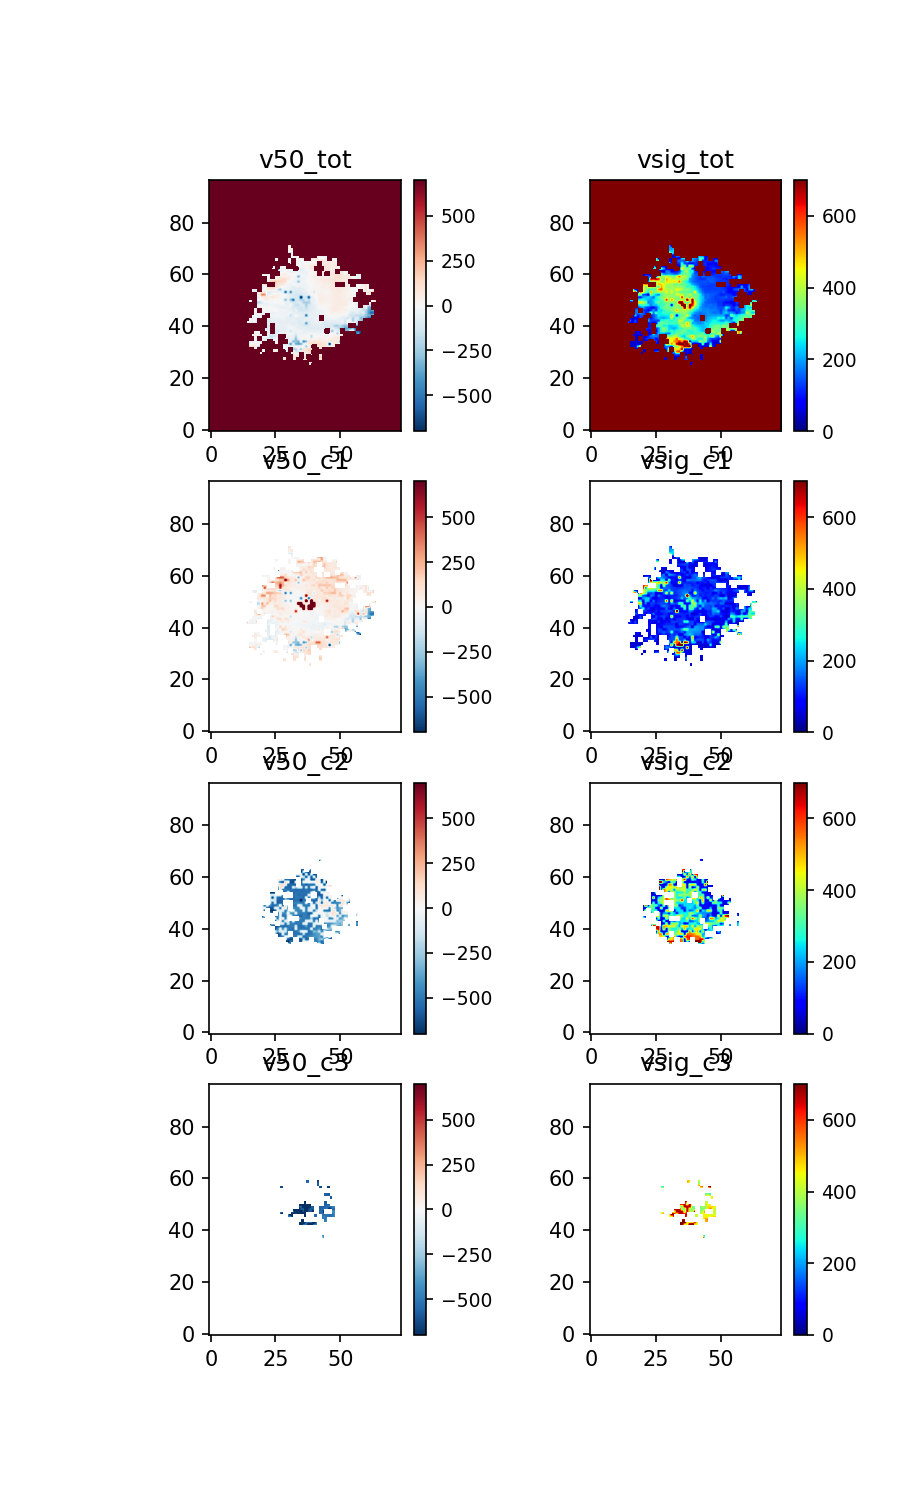

In [61]:
%matplotlib notebook
with fits.open(fits_hdul_name) as hdul:

    fc2 = hdul[1].data['fc2']
    err_fc2 = hdul[1].data['err_fc2']
    v50_tot = hdul[1].data['v50_tot']
    v50_c1 = hdul[1].data['v50_c1']
    v50_c2 = hdul[1].data['v50_c2']
    v50_c3 = hdul[1].data['v50_c3']
    vsig_tot = hdul[1].data['vsig_tot']
    vsig_c1 = hdul[1].data['vsig_c1']
    vsig_c2 = hdul[1].data['vsig_c2']
    vsig_c3 = hdul[1].data['vsig_c3']
    

    spx_x = 36
    spx_y = 50

    figure(figsize=(6,10))

    subplot(421)
    imshow(v50_tot, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('v50_tot')
    
    subplot(422)
    imshow(vsig_tot, origin='lower', cmap='jet',vmin=0,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('vsig_tot')
    
    subplot(423)
    imshow(v50_c1, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('v50_c1')

    subplot(424)
    imshow(vsig_c1, origin='lower', cmap='jet',vmin=0,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('vsig_c1')
    
    subplot(425)
    imshow(v50_c2, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('v50_c2')
    
    subplot(426)
    imshow(vsig_c2, origin='lower', cmap='jet',vmin=0,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('vsig_c2')
    
    subplot(427)
    imshow(v50_c3, origin='lower', cmap='RdBu_r',vmin=-700,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('v50_c3')
    
    subplot(428)
    imshow(vsig_c3, origin='lower', cmap='jet',vmin=0,vmax=700)
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    ax.title.set_text('vsig_c3')
    
#     plt.savefig('v502-250_vsig2-100_cut.png')


In [4]:
with fits.open('F05189_full_2comp_flipped-1comp.fits') as hdul:
    fc2 = hdul[1].data['fc2']
    err_fc2 = hdul[1].data['err_fc2']
    v50_tot = hdul[1].data['v50_tot']
    v50_c1 = hdul[1].data['v50_c1']
    v50_c2 = hdul[1].data['v50_c2']
    vsig_tot = hdul[1].data['vsig_tot']
    vsig_c1 = hdul[1].data['vsig_c1']
    vsig_c2 = hdul[1].data['vsig_c2']
    flipinfo = hdul[1].data['flipinfo']
    
    # 53,47 53,48
    print('53,47: v50_c1:', round(v50_c1[46][52],1), '|| v50_c2:', round(v50_c2[46][52],1), '|| vsig_c1:', round(vsig_c1[46][52],1), '|| vsig_c2:', round(vsig_c2[46][52],1), '|| flipinfo:', flipinfo[46][52])
    print('####')
    print('53,48: v50_c1:', round(v50_c1[47][52],1), '|| v50_c2:', round(v50_c2[47][52],1), '|| vsig_c1:', round(vsig_c1[47][52],1), '|| vsig_c2:', round(vsig_c2[47][52],1), '|| flipinfo:', flipinfo[47][52])
    

53,47: v50_c1: -11.0 || v50_c2: -625.9 || vsig_c1: 87.9 || vsig_c2: 435.9 || flipinfo: 0.0
####
53,48: v50_c1: 1.4 || v50_c2: -627.3 || vsig_c1: 116.1 || vsig_c2: 366.1 || flipinfo: 0.0
